In [ ]:
import matplotlib as mpl

# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.image as mpimg

import torch

from sbi.analysis import pairplot

# load and read nwb files
from pynwb import NWBHDF5IO

import sys
sys.path.append('../../code')

from ephys_utils import get_time_voltage_current_currindex0_gouwens
from simulator import EphysModel_Gouwens
from plot_utils import adjust_spines

### Load observed data
Load the summary statistics of raw membrane voltage recordings generated with `../code/preprocess.ipynb`.

In [3]:
V1_25degree = pickle.load(open('../../code/pickles/V1_features.pickle', 'rb'))
ephys_features = np.array(V1_25degree['X_o'].columns)[:-1]
Xo = V1_25degree['X_o'].copy()
V1_names = V1_25degree['V1_names']

In [4]:
v1_meta = pd.read_csv('../../data/Gouwens (2020)/20200625_patchseq_metadata_mouse.csv')
v1_meta = v1_meta.set_index('ephys_session_id')
v1_meta = v1_meta.reindex(Xo.index.astype('int64'))
celltypes = v1_meta['corresponding_AIT2.3.1_alias']
v1_meta.shape

(4107, 21)

In [5]:
celltype_Vip, celltype_Sst, celltype_Lamp5, celltype_Pvalb, celltype_Sncg, celltype_Serpinf1 = \
    [False]*celltypes.shape[0], [False]*celltypes.shape[0], [False]*celltypes.shape[0], \
        [False]*celltypes.shape[0], [False]*celltypes.shape[0], [False]*celltypes.shape[0]

for i, ct in enumerate(celltypes):
    if isinstance(ct, str):
        if ct.split(' ')[0]=='Vip':
            celltype_Vip[i]=True
        elif ct.split(' ')[0]=='Sst':
            celltype_Sst[i]=True
        elif ct.split(' ')[0]=='Lamp5':
            celltype_Lamp5[i]=True
        elif ct.split(' ')[0]=='Pvalb':
            celltype_Pvalb[i]=True
        elif ct.split(' ')[0]=='Sncg':
            celltype_Sncg[i]=True
        elif ct.split(' ')[0]=='Serpinf1':
            celltype_Serpinf1[i]=True

In [6]:
model_param_names = np.array(['C', r'$R_{input}$', r'$\tau$', r'$g_{Nat}$', r'$g_{Na}$', r'$g_{Kd}$', r'$g_{M}$',
                         r'$g_{Kv31}$', r'$g_{L}$', r'$E_{leak}$', r'$\tau_{max}$', 'VT', 'rate_to_SS_factor', 'I'])
prior_min = [0.1,  20,  0.1,    0,        0,      0,      0,      0,      0, -130,    50,    -90,   0.1,   20]
prior_max = [15,   1000,   70,   250,     100,      30,    3,     250,     3,  -50,  4000,   -35,    3,   870]

### Figure 4

Illustrate model mismatch

In [7]:
dir_locs = []
for cell_name in Xo.index:
    dir_locs.append('../'+
        np.array(V1_25degree["V1_names"])[
            np.where(Xo.index == cell_name)[0][0]
        ]
    )

Pick example cell

In [8]:
cell_name = Xo.index[celltype_Serpinf1][1]
cell_name

'992249152'

In [10]:
# Check whether raw file name corresponds to the cell's name
data = np.array(V1_25degree["V1_names"])[
    np.where(Xo.index == cell_name)[0][0]
]
data

'../data/Gouwens (2020)/raw_data/000020/sub-985736139/sub-985736139_ses-992249152_icephys.nwb'

In [11]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data = NWBHDF5IO('../'+data, "r", load_namespaces=True).read()

In [12]:
xo = Xo.loc[cell_name, :].iloc[:-1].values
feature_list = range(23)

In [14]:
liquid_junction_potential = 14
time_obs, voltage_obs, current_obs, curr_obs_applied = get_time_voltage_current_currindex0_gouwens(data)
voltage_obs -= liquid_junction_potential
observation = {'data': voltage_obs[np.newaxis,:], \
                'time': time_obs*1e3, 'dt':2e-5*1e3, 'I': current_obs}

In [15]:
lw = 2

In [20]:
celltypes[int(cell_name)]

'Serpinf1 Aqp5 Vip'

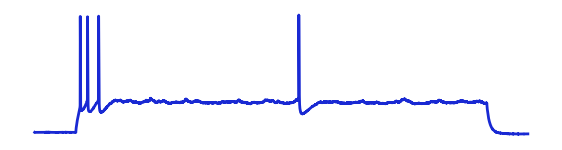

In [22]:
fig, ax_obs = plt.subplots(1, 1, figsize=(7, 1.7))
# Experimental observation
ax_obs.plot(observation["time"], observation["data"][0,:], c="#1929d3ff", lw=lw)
sns.despine(left=True, bottom=True, ax=ax_obs)
ax_obs.set_xticks([])
ax_obs.set_yticks([])
plt.savefig(
    "preliminary/observation_example.png", bbox_inches="tight", pad_inches=0, dpi=500
)

In [23]:
# load prior simulations
theta = np.load("../../code/save_sims/V1_chunks/full_batch.npz")["theta"]
stats = np.load("../../code/save_sims/V1_chunks/full_batch.npz")["stats"]
keeping = (~np.isnan(np.mean(stats, axis=1))) & (
    ~np.isinf(np.mean(stats, axis=1))
)  # delete non-spiking simulations
stats = stats[keeping, :]
theta = theta[keeping, :]

In [24]:
# find 1000 prior simulations closest to the experimental observation in terms of Z-scored ephys distance
s_mean = stats[:, feature_list].mean(axis=0)
s_std = stats[:, feature_list].std(axis=0)
E_distances = np.sort(
    np.sqrt(
        np.sum(
            (
                (stats[:, feature_list] - s_mean) / s_std
                - (xo[feature_list] - s_mean) / s_std
            )
            ** 2,
            axis=1,
        )
    )
)[0:1000]

Next blocks can take a while. If performed once, you don't need to run it again and can just go to loading the saved files.

In [ ]:
# Uncomment this block to recompute

# now do it for all experimental observations
s_mean=stats[:,feature_list].mean(axis=0)
s_std=stats[:,feature_list].std(axis=0)
E_distances_observations=[]
for i in range(Xo.shape[0]):
    if i%10==0:
        print(i,' ', end='')
    E_distances_one=np.sort(
        np.sqrt(
            np.sum(
                (
                    (stats[:,feature_list]-s_mean)/s_std
                    -(Xo.values[i,feature_list]-s_mean)/s_std
                )**2,axis=1
            )
        )
    )[0:1000]
    E_distances_observations.append(E_distances_one)
E_distances_observations=np.array(E_distances_observations)
np.savez('../../code/save_sims/E_distances_observations_V1.npz',
     distances=E_distances_observations
        )

0  10  20  30  40  50  60  70  

KeyboardInterrupt: 

In [ ]:
#Uncomment this block to recompute

# pick 1000 random prior simulations and perform for each of them an analogous analysis
selected_random_sims=np.random.randint(0,stats.shape[0],1000)
stats_picked=stats[selected_random_sims,:]
E_distances_prior=[]
for i in range(1000):
    if i%10==0:
        print(i,' ', end='')
    E_distances_prior_one=np.sort(
        np.sqrt(
            np.sum(
                (
                    (stats[:,feature_list]-s_mean)/s_std
                    -(stats_picked[i,feature_list]-s_mean)/s_std
                )**2,axis=1
            )
        )
    )[0:1000]
    E_distances_prior.append(E_distances_prior_one)
E_distances_prior=np.array(E_distances_prior)
np.savez('../../code/save_sims/E_distances_prior_V1.npz',
     distances=E_distances_prior,
     indices=selected_random_sims
    )

0  10  20  30  40  50  60  70  80  90  100  110  120  130  140  150  160  170  180  190  200  210  220  

In [ ]:
E_distances_prior = np.load("../../code/save_sims/E_distances_prior_V1.npz")["distances"]
E_distances_prior_indices = np.load("../../code/save_sims/E_distances_prior_V1.npz")[
    "indices"
]
E_distances_observations = np.load("../../code/save_sims/E_distances_observations_V1.npz")[
    "distances"
]

In [ ]:
V1_model=EphysModel_Gouwens(name='V1',
                   T=34.0,
                   E_Na=53.5,
                   E_K=-101.3,
                   E_Ca=131.1,
                   start=100,
                   end=1100,
                   dt=0.04,
                   n_processes=1,
                   noise_factor=10,
                   use_pathos=False,
                   chunk_size=1000,
                   save_chunks=False)

In [ ]:
s_mean = stats[:, feature_list].mean(axis=0)
s_std = stats[:, feature_list].std(axis=0)
E_distances_indexes = np.argsort(
    np.sqrt(
        np.sum(
            (
                (stats[:, feature_list] - s_mean) / s_std
                - (xo[feature_list] - s_mean) / s_std
            )
            ** 2,
            axis=1,
        )
    )
)[0:1000]
x_prior = V1_model._run_HH_model(theta[E_distances_indexes[[1, 500]], :])

INFO       Overwriting environment variable "DYLD_LIBRARY_PATH" [brian2.devices.cpp_standalone.device.overwritten_env_var]


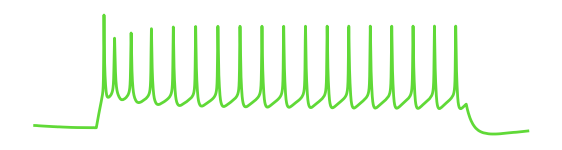

In [ ]:
fig, ax_sim = plt.subplots(1, 1, figsize=(7, 1.7))
# Prior simulation
x_prior_example = V1_model._run_HH_model(theta[E_distances_indexes[1], :])
ax_sim.plot(
    x_prior_example["time"], x_prior_example["data"][0, 0, :], c="#60D937", lw=lw
)
sns.despine(left=True, bottom=True, ax=ax_sim)
ax_sim.set_xticks([])
ax_sim.set_yticks([])
plt.savefig(
    "preliminary/very_close_simulation.png", bbox_inches="tight", pad_inches=0, dpi=500
)

In [83]:
sim_ind_ex = E_distances_prior_indices[
    np.argsort(E_distances_prior[:, -1])[round(E_distances_prior.shape[0] // 2.2)]
]

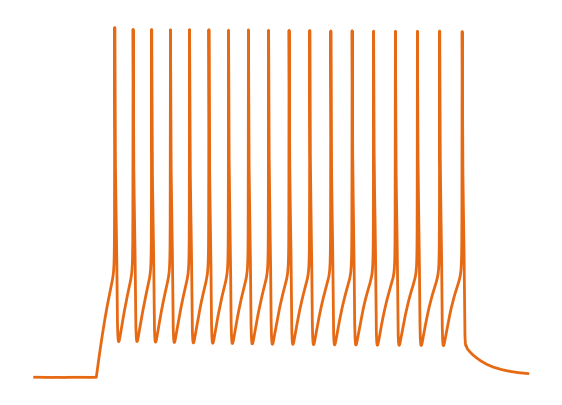

In [ ]:
fig, ax_sim = plt.subplots(1, 1, figsize=(7, 5))
# Prior simulation
x_prior_example = V1_model._run_HH_model(theta[sim_ind_ex, :])
ax_sim.plot(
    x_prior_example["time"], x_prior_example["data"][0, 0, :], c="#e66913ff", lw=lw
)
sns.despine(left=True, bottom=True, ax=ax_sim)
ax_sim.set_xticks([])
ax_sim.set_yticks([])
plt.savefig(
    "preliminary/simulation_example.png", bbox_inches="tight", pad_inches=0, dpi=500
)

In [79]:
# find 1000 prior simulations closest to a simulation in terms of Z-scored ephys distance
s_mean = stats[:, feature_list].mean(axis=0)
s_std = stats[:, feature_list].std(axis=0)
E_distances_ex = np.sort(
    np.sqrt(
        np.sum(
            (
                (stats[:, feature_list] - s_mean) / s_std
                - (stats[sim_ind_ex, feature_list] - s_mean) / s_std
            )
            ** 2,
            axis=1,
        )
    )
)[0:1000]

In [ ]:
s_mean = stats[:, feature_list].mean(axis=0)
s_std = stats[:, feature_list].std(axis=0)
E_distances_ex_indexes = np.argsort(
    np.sqrt(
        np.sum(
            (
                (stats[:, feature_list] - s_mean) / s_std
                - (stats[sim_ind_ex, feature_list] - s_mean) / s_std
            )
            ** 2,
            axis=1,
        )
    )
)[0:1000]
x_sim_prior = V1_model._run_HH_model(theta[E_distances_ex_indexes[[1, 500]], :])

In [ ]:
x_sim_ex = V1_model._run_HH_model(theta[sim_ind_ex, :])

In [83]:
fancy_colors = (
    np.array(
        [
            [86, 100, 26],
            [192, 175, 251],
            [230, 161, 118],
            [0, 103, 138],
            [152, 68, 100],
            [94, 204, 171],
            [205, 205, 205],
        ]
    )
    / 255
)

In [84]:
def create_figure_4(fig):
    if fig is None:
        fig = plt.figure(figsize=(14, 6))
    else:
        fig = fig

    width = 0.23  # for membrane voltage traces
    height = 0.19  # for membrane voltage traces

    ax_schema = plt.axes([-0.2, 0.55, 1.2, 0.47])
    ax_mm_banana = plt.axes([0, 0.15, 0.36, 0.38])

    ax_obs = plt.axes([0.36, 0.37, width, height])
    ax_obs_sim = plt.axes([0.58, 0.37, width, height])
    ax_sim = plt.axes([0.36, 0.17, width, height])
    ax_sim_sim = plt.axes([0.58, 0.15, width, height])

    return ax_schema, ax_mm_banana, ax_obs, ax_obs_sim, ax_sim, ax_sim_sim

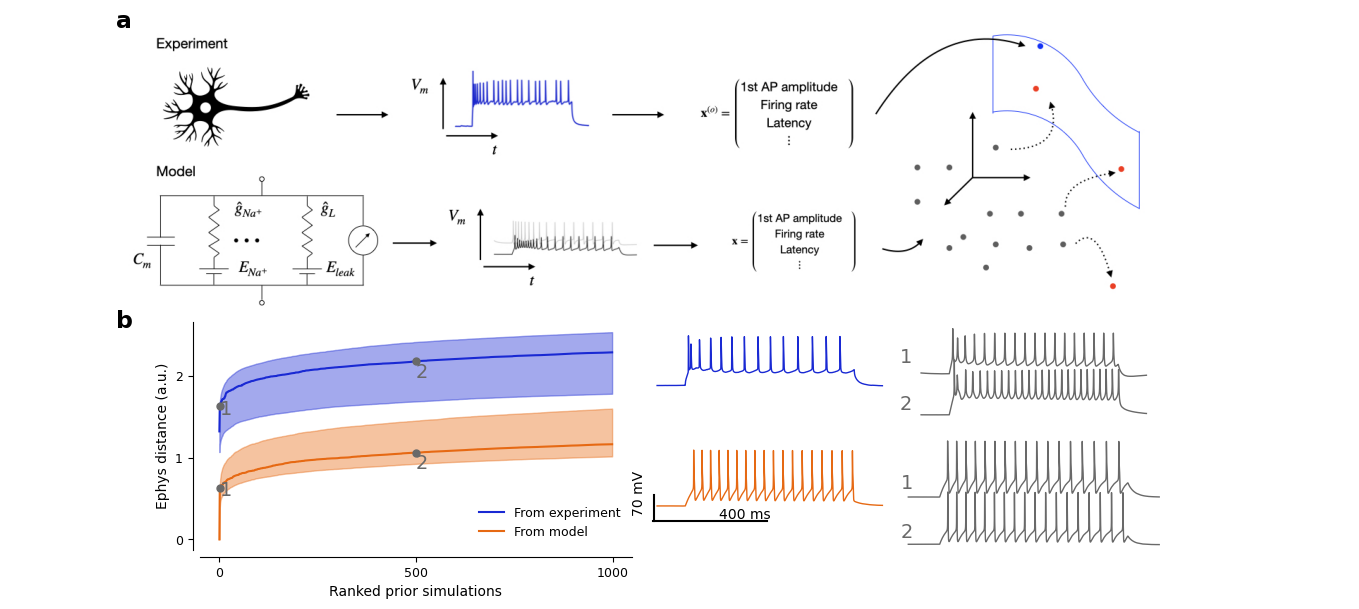

In [89]:
fig = plt.figure(figsize=(12, 6))
ax_schema, ax_mm_banana, ax_obs, ax_obs_sim, ax_sim, ax_sim_sim = create_figure_4(fig)

lw = 1

# Model mismatch, sketch
img_file = os.listdir("sketches/")[0]
img = mpimg.imread("sketches/" + img_file)

ax_schema.imshow(img)
ax_schema.set_xticks([])
ax_schema.set_yticks([])
sns.despine(ax=ax_schema, left=True, bottom=True)

# Model mismatch, banana
ax_mm_banana.plot(range(1000), E_distances, c="#1929d3ff", label="From experiment")
ax_mm_banana.plot(E_distances_ex, c="#e66913ff", label="From model")
ax_mm_banana.fill_between(
    range(1000),
    np.percentile(E_distances_prior, 30, axis=0),
    np.percentile(E_distances_prior, 70, axis=0),
    color="#e66913ff",
    alpha=0.4,
)
ax_mm_banana.fill_between(
    range(1000),
    np.percentile(E_distances_observations, 30, axis=0),
    np.percentile(E_distances_observations, 70, axis=0),
    color="#1929d3ff",
    alpha=0.4,
)

ax_mm_banana.plot([1], [E_distances[1]], color="dimgray", marker=".", markersize=10)
ax_mm_banana.plot([500], [E_distances[500]], color="dimgray", marker=".", markersize=10)
ax_mm_banana.plot([1], [E_distances_ex[1]], color="dimgray", marker=".", markersize=10)
ax_mm_banana.plot(
    [500], [E_distances_ex[500]], color="dimgray", marker=".", markersize=10
)

ax_mm_banana.annotate("1", (1, E_distances[1] - 0.1), color="dimgray", fontsize=14)
ax_mm_banana.annotate("2", (500, E_distances[500] - 0.2), color="dimgray", fontsize=14)
ax_mm_banana.annotate("1", (1, E_distances_ex[1] - 0.1), color="dimgray", fontsize=14)

ax_mm_banana.annotate(
    "2", (500, E_distances_ex[500] - 0.2), color="dimgray", fontsize=14
)
ax_mm_banana.set_xlabel("Ranked prior simulations", fontsize=10)
ax_mm_banana.set_ylabel("Ephys distance (a.u.)", fontsize=10)

ax_mm_banana.set_xticks([0, 500, 1000])
ax_mm_banana.set_yticks([0, 1, 2])
ax_mm_banana.tick_params(axis="both", which="major", labelsize=9)

ax_mm_banana.legend(loc="lower right", fontsize=9, frameon=False)

adjust_spines(ax_mm_banana, spines=["bottom", "left"])

# Experimental observation and prior simulations close to it
ax_obs.plot(observation["time"], observation["data"], c="#1929d3ff", lw=lw)
ax_obs.set_ylim([ax_obs.get_ylim()[0] - 70, ax_obs.get_ylim()[1] + 70])
ax_obs.set_xlim([ax_obs.get_xlim()[0] - 50, ax_obs.get_xlim()[1] + 50])

ax_obs.set_xticks([])
ax_obs.set_yticks([])
sns.despine(ax=ax_obs, bottom=True, left=True)


ax_obs_sim.plot(x_prior["time"], x_prior["data"][0, 0, :] + 20, lw=lw, color="dimgray")
ax_obs_sim.plot(x_prior["time"], x_prior["data"][1, 0, :] - 60, lw=lw, color="dimgray")

ax_obs_sim.set_xlim([ax_obs.get_xlim()[0], ax_obs.get_xlim()[1]])
ax_obs_sim.set_ylim([ax_obs.get_ylim()[0], ax_obs.get_ylim()[1]])
ax_obs_sim.annotate(
    1,
    (ax_obs.get_xlim()[0] + 15, ax_obs.get_ylim()[1] - 140),
    fontsize=14,
    c="dimgray",
)
ax_obs_sim.annotate(
    2,
    (ax_obs.get_xlim()[0] + 15, ax_obs.get_ylim()[1] - 250),
    fontsize=14,
    c="dimgray",
)
ax_obs_sim.set_xticks([])
ax_obs_sim.set_yticks([])
sns.despine(ax=ax_obs_sim, bottom=True, left=True)


# Prior simulation and prior simulations close to it
ax_sim.plot(x_sim_ex["time"], x_sim_ex["data"][0, 0, :], c="#e66913ff", lw=lw)
ax_sim.set_ylim([ax_obs.get_ylim()[0] - 20, ax_obs.get_ylim()[1] + 20])
ax_sim.set_xlim([ax_obs.get_xlim()[0], ax_obs.get_xlim()[1]])
ax_sim.set_xticks([])
ax_sim.set_yticks([])
sns.despine(ax=ax_sim, bottom=True, left=True)


ax_sim_sim.plot(
    x_sim_prior["time"], x_sim_prior["data"][0, 0, :] + 20, lw=lw, color="dimgray"
)
ax_sim_sim.plot(
    x_sim_prior["time"], x_sim_prior["data"][1, 0, :] - 110, lw=lw, color="dimgray"
)
ax_sim_sim.set_xlim([ax_sim_sim.get_xlim()[0], ax_sim_sim.get_xlim()[1]])
ax_sim_sim.set_ylim([ax_sim_sim.get_ylim()[0], ax_sim_sim.get_ylim()[1]])
ax_sim_sim.annotate(
    1,
    (ax_sim_sim.get_xlim()[0] + 15, ax_sim_sim.get_ylim()[1] - 140),
    fontsize=14,
    c="dimgray",
)
ax_sim_sim.annotate(
    2,
    (ax_sim_sim.get_xlim()[0] + 15, ax_sim_sim.get_ylim()[1] - 270),
    fontsize=14,
    c="dimgray",
)
ax_sim_sim.set_xticks([])
ax_sim_sim.set_yticks([])
sns.despine(ax=ax_sim_sim, bottom=True, left=True)

ax_sim.plot([-15, 390], [-140, -140], "k")
ax_sim.annotate("400 ms", (220, -135))
ax_sim.plot([-10, -10], [-140, -70], "k")
ax_sim.annotate("70 mV", (-89, -120), rotation=90)

fig.text(-0.07, 1.02, "a", fontsize=17, fontweight="bold")
fig.text(-0.07, 0.52, "b", fontsize=17, fontweight="bold")

plt.savefig("figure_4.png", bbox_inches="tight", pad_inches=0)
plt.savefig("figure_4.pdf", bbox_inches="tight", pad_inches=0)

### Figure 3

How we overcome model mismatch with neural posterior estimation.

In [ ]:
with open("../../code/save_posteriors/training_schedule_0.pickle", "rb") as f:
    npe_posterior = pickle.load(f)
with open("../../code/save_posteriors/training_schedule_2d.pickle", "rb") as f:
    npep_posterior = pickle.load(f)

Fetch 3 posterior samples with highest posterior weight. Get there corresponding simulations and summary statistics. You can also immediately load the simulations that come with the figure from the GitHub repo and skip this cell.

In [ ]:
Uncomment this block to recompute

npe_samples=npe_posterior.sample(
    (10000,),
    x=torch.as_tensor(xo[feature_list], dtype=float),
)
npe_samples=npe_samples[np.argsort(np.array(npe_posterior.log_prob(theta=npe_samples, x=xo[feature_list])))[-3:],:]
npep_samples=npep_posterior.sample(
    (10000,),
    x=torch.as_tensor(xo[feature_list], dtype=float),
)
npep_samples=npep_samples[np.argsort(np.array(npep_posterior.log_prob(theta=npep_samples, x=xo[feature_list])))[-3:],:]
x_npe=V1_model._run_HH_model(npe_samples.numpy())
x_npep=V1_model._run_HH_model(npep_samples.numpy())

summ_stats_npe=V1_model._simulation_wrapper(npe_samples[-1,:].numpy()[np.newaxis,:]).numpy()[0,:]
summ_stats_npep=V1_model._simulation_wrapper(npep_samples[-1,:].numpy()[np.newaxis,:]).numpy()[0,:]

fig_1_sims_to_show={
    'npe':{'samples':npe_samples, 'x':x_npe, 'summ_stats':summ_stats_npe},
    'npep':{'samples':npep_samples, 'x':x_npep, 'summ_stats':summ_stats_npep}
}

with open('../../code/save_model_parameters/fig_3_sims_to_show_V1.pickle', 'wb') as f:
    pickle.dump(fig_1_sims_to_show, f)

In [ ]:
with open("../../code/save_model_parameters/fig_3_sims_to_show_V1.pickle", "rb") as f:
    fig_3_sims_to_show = pickle.load(f)

In [130]:
npe_samples = fig_3_sims_to_show["npe"]["samples"]
x_npe = fig_3_sims_to_show["npe"]["x"]
summ_stats_npe = fig_3_sims_to_show["npe"]["summ_stats"]

npen_samples = fig_3_sims_to_show["npep"]["samples"]
x_npen = fig_3_sims_to_show["npep"]["x"]
summ_stats_npen = fig_3_sims_to_show["npep"]["summ_stats"]

In [132]:
obs_index = np.where(Xo.index == cell_name)[0][0]

# best_prior_stats = np.load("../code/save_sims/best_1000_Euclidean_sims.npz")["stats"][
#    ::1000, :
# ]
# best_prior_stats_nans = np.isnan(best_prior_stats.sum(axis=1))

Xo_values = Xo.values[:, :-4]
Xo_mean = Xo.values[:, :-4].mean(axis=0)
Xo_std = Xo.values[:, :-4].std(axis=0)


# prior_score = np.sqrt(
#    (
#        (best_prior_stats[obs_index, :] - Xo_mean) / Xo_std
#        - (Xo_values[obs_index, :] - Xo_mean) / Xo_std
#    )
#    ** 2
# )

npe_score = np.sqrt(
    ((summ_stats_npe - Xo_mean) / Xo_std - (Xo_values[obs_index, :] - Xo_mean) / Xo_std)
    ** 2
)

npen_score = np.sqrt(
    (
        (summ_stats_npen - Xo_mean) / Xo_std
        - (Xo_values[obs_index, :] - Xo_mean) / Xo_std
    )
    ** 2
)

In [134]:
mpl.rcParams.update({"font.size": 14})

In [136]:
def create_figure_3(fig):
    if fig is None:
        fig = plt.figure(figsize=(14, 5))
    else:
        fig = fig

    width, height = 0.04, 0.12
    ax_features = plt.axes([0, 0, 0.12, 1])
    ax_observation = plt.axes([0.02, 0.01, width + 0.15, height + 0.03])
    axes_npe = np.array(
        [
            [
                plt.axes([0.15 + x, y, width, height])
                for x in [0, 0.06, 0.12, 0.18, 0.24, 0.3, 0.36]
            ]
            for y in [0.86, 0.72, 0.58, 0.44, 0.3, 0.16, 0.02]
        ]
    )

    ax_npe_s1 = plt.axes([0.13, 0.3, width + 0.15, height + 0.03])
    ax_npe_s2 = plt.axes([0.18, 0.15, width + 0.15, height + 0.03])
    ax_npe_s3 = plt.axes([0.23, 0, width + 0.15, height + 0.03])

    axes_npep = np.array(
        [
            [
                plt.axes([0.58 + x, y, width, height])
                for x in [0, 0.06, 0.12, 0.18, 0.24, 0.3, 0.36]
            ]
            for y in [0.86, 0.72, 0.58, 0.44, 0.3, 0.16, 0.02]
        ]
    )

    ax_npep_s1 = plt.axes([0.56, 0.3, width + 0.15, height + 0.03])
    ax_npep_s2 = plt.axes([0.61, 0.15, width + 0.15, height + 0.03])
    ax_npep_s3 = plt.axes([0.66, 0, width + 0.15, height + 0.03])

    return [
        ax_features,
        ax_observation,
        axes_npe,
        axes_npep,
        ax_npe_s1,
        ax_npe_s2,
        ax_npe_s3,
        ax_npep_s1,
        ax_npep_s2,
        ax_npep_s3,
    ]

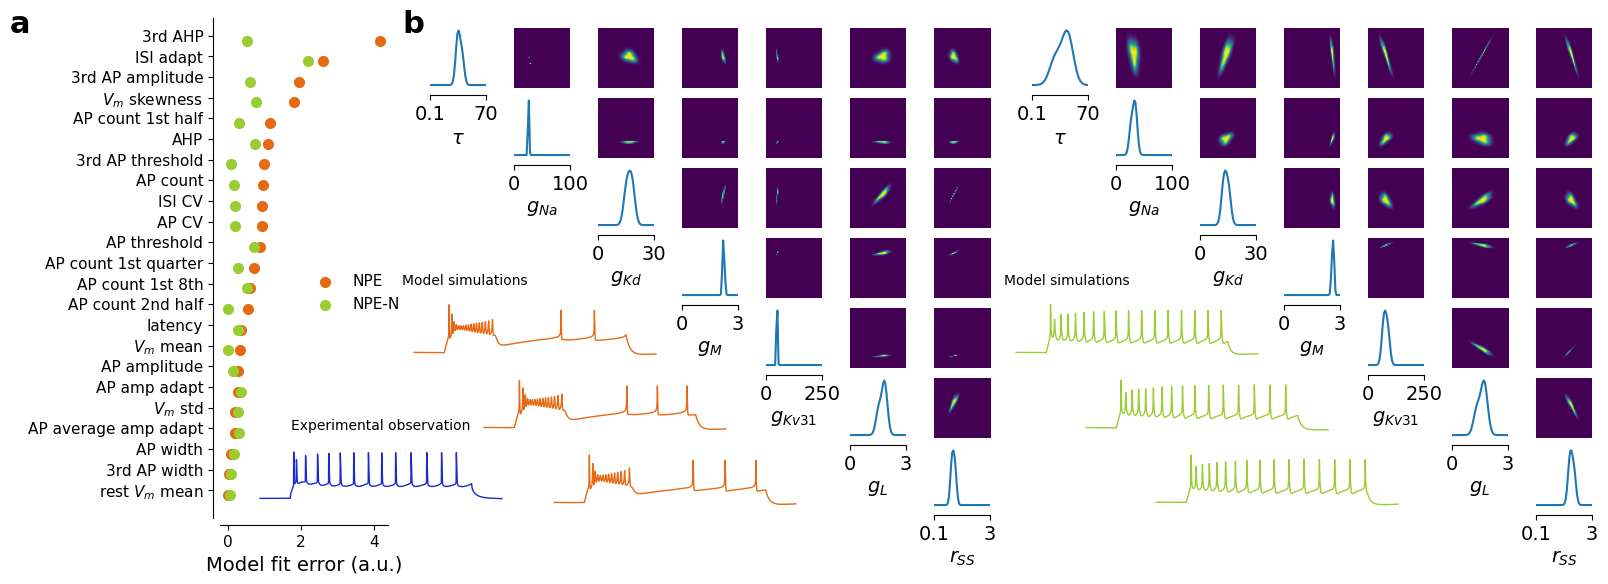

In [138]:
dims_to_show = [2, 4, 5, 6, 7, 8, 12]

fig = plt.figure(figsize=(14, 5))
ax_list = create_figure_3(fig)

ax_features = ax_list[0]

# Feature-wise performances NPE vs NPE-N
order = np.argsort(npe_score)

ax_features.scatter(
    npe_score[order],
    np.linspace(0, 4 * len(ephys_features) + 1, num=len(ephys_features)),
    color="#e66913ff",
    label="NPE",
    lw=2,
)
ax_features.scatter(
    npen_score[order],
    np.linspace(0, 4 * len(ephys_features) + 1, num=len(ephys_features)),
    color="yellowgreen",
    label="NPE-N",
    lw=2,
)
adjust_spines(ax_features, spines=["bottom", "left"])
ax_features.set_yticks(
    np.linspace(1, 4 * len(ephys_features) + 2, num=len(ephys_features))
)
ax_features.legend(loc=(0.5, 0.4), fontsize=11, frameon=False)
ax_features.set_xlabel("Model fit error (a.u.)", fontsize=14)
ax_features.set_yticklabels(ephys_features[order])
ax_features.tick_params(axis="y", which="major", labelsize=11)
ax_features.tick_params(axis="x", which="major", labelsize=11)

ax_observation = ax_list[1]

# Experimental observation
ax_observation.plot(observation["time"], observation["data"], c="#1929d3ff", lw=lw)
ax_observation.set_ylim(
    [ax_observation.get_ylim()[0] - 30, ax_observation.get_ylim()[1] + 30]
)
ax_observation.set_xticks([])
ax_observation.set_yticks([])
sns.despine(ax=ax_observation, bottom=True, left=True)
ax_observation.set_title("Experimental observation", fontsize=10)

axes_npe = ax_list[2]

# npe pairplot
pairplot(
    npe_samples[:, dims_to_show],
    limits=list(
        zip(np.array(prior_min)[dims_to_show], np.array(prior_max)[dims_to_show])
    ),
    ticks=list(
        zip(np.array(prior_min)[dims_to_show], np.array(prior_max)[dims_to_show])
    ),
    labels=list(model_param_names[dims_to_show]),
    points_offdiag={"markersize": 6},
    points_colors="r",
    fig=fig,
    axes=axes_npe,
    upper="kde",
    diag="kde",
)

ax_npe_s1, ax_npe_s2, ax_npe_s3 = ax_list[4], ax_list[5], ax_list[6]

ax_npe_s1.plot(x_npe["time"], x_npe["data"][0, 0, :], lw=lw, color="#e66913ff")
ax_npe_s2.plot(x_npe["time"], x_npe["data"][1, 0, :], lw=lw, color="#e66913ff")
ax_npe_s3.plot(x_npe["time"], x_npe["data"][2, 0, :], lw=lw, color="#e66913ff")

axes_npen = ax_list[3]

# npe-n pairplot
pairplot(
    npen_samples[:, dims_to_show],
    limits=list(
        zip(np.array(prior_min)[dims_to_show], np.array(prior_max)[dims_to_show])
    ),
    ticks=list(
        zip(np.array(prior_min)[dims_to_show], np.array(prior_max)[dims_to_show])
    ),
    labels=list(model_param_names[dims_to_show]),
    points_offdiag={"markersize": 6},
    points_colors="r",
    fig=fig,
    axes=axes_npen,
    upper="kde",
    diag="kde",
)

ax_npen_s1, ax_npen_s2, ax_npen_s3 = ax_list[7], ax_list[8], ax_list[9]

ax_npen_s1.plot(x_npen["time"], x_npen["data"][0, 0, :], lw=lw, color="yellowgreen")
ax_npen_s2.plot(x_npen["time"], x_npen["data"][1, 0, :], lw=lw, color="yellowgreen")
ax_npen_s3.plot(x_npen["time"], x_npen["data"][2, 0, :], lw=lw, color="yellowgreen")

for ax in [ax_npe_s1, ax_npe_s2, ax_npe_s3, ax_npen_s1, ax_npen_s2, ax_npen_s3]:
    ax.set_ylim([ax_observation.get_ylim()[0], ax_observation.get_ylim()[1]])
    ax.set_xlim([ax_observation.get_xlim()[0], ax_observation.get_xlim()[1]])
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, bottom=True, left=True)
ax_npe_s1.set_title("Model simulations", fontsize=10, loc="left")
ax_npen_s1.set_title("Model simulations", fontsize=10, loc="left")

fig.text(-0.15, 0.97, "a", fontsize=22, fontweight="bold")
fig.text(0.13, 0.97, "b", fontsize=22, fontweight="bold")

plt.savefig("figure_3.pdf", bbox_inches="tight", pad_inches=0)
plt.savefig("figure_3.png", bbox_inches="tight", pad_inches=0)